# Projet AXA

## Requirement

In [192]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from datetime import datetime
import error_functions as ef
from dateutil import relativedelta
from workalendar.europe import France

In [193]:
blue_light = '#029aed'
orange_med = '#ff5722'
green_light = '#63a600'
gray_light = '#666666'
cal = France()

## Loading data

In [194]:
holiday_map = pd.DataFrame()
for year in [2011,2012,2013,2014]:
    holiday_map_temp = pd.DataFrame(cal.holidays(year))
    holiday_map_temp = holiday_map_temp.set_index([0])
    holiday_map = pd.concat([holiday_map, holiday_map_temp], ignore_index=False)
holiday_map.head()  

,1
0,
2011-01-01,New year
2011-04-25,Easter Monday
2011-05-01,Labour Day
2011-05-08,Victory in Europe Day
2011-06-02,Ascension Thursday


In [80]:
# loading the train data
data = pd.read_csv('data/train.csv', sep=";", parse_dates=['DATE'], index_col = ['DATE'], nrows = 3*10e5)
data['DATE'] = data.index
# data.head()

# loading the test data
submission = pd.read_csv('documentation/submission.txt', sep="\t", parse_dates=['DATE'], index_col = ['DATE'])
submission['DATE'] = submission.index
# submission.head()

## Data transformation

In [206]:
# timestamp exctraction
def splitDatetime(data) :
    datatime = pd.DatetimeIndex(data.DATE)
    data['year'] = datatime.year
    data['month'] = datatime.month
    data['day'] = datatime.day
    data['hour'] = datatime.hour
    data['min'] = datatime.minute
    data['dayweek'] = datatime.weekday
    data['workingday'] = (datatime.weekday < 6).astype(int)
    data['holiday'] = data.index.isin(holiday_map.index).astype(int)
    return data

data = splitDatetime(data)
submission = splitDatetime(submission)
# submission.head()
# data.head()

### Labels/Features definition

In [207]:
X = pd.DataFrame()
X = data[['year','month','day','hour','ASS_ASSIGNMENT','CSPL_CALLS','min','DATE']]
df1 = X.pivot_table(index = ['DATE'], columns = ['ASS_ASSIGNMENT'], values = ['CSPL_CALLS'], aggfunc=np.sum)
# print(df1.shape)
df1.fillna(0, inplace=True)
# df1.head()

y_df = pd.DataFrame()
for cat in data.ASS_ASSIGNMENT.unique() :
    y_df[cat] = df1['CSPL_CALLS'][cat]
y_df.head()

,Téléphonie,RTC,Gestion Renault,Nuit,Gestion - Accueil Telephonique,Regulation Medicale,Services,Tech. Total,Gestion Relation Clienteles,Crises,...,Tech. Inter,Gestion Clients,Manager,Tech. Axa,CAT,Gestion DZ,Mécanicien,CMS,Prestataires,Evenements
DATE,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,1.0,0.0,0.0,16.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:30:00,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,28.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
X_test = pd.DataFrame(index = submission.index)
X_test['DATE'] = submission.index
X_test = splitDatetime(X_test)
X_test.drop('DATE', axis=1, inplace=True)
X_test = X_test.drop_duplicates()

date_min_test = X_test.index.min()
date_max_test = X_test.index.max()
X_test_range = relativedelta.relativedelta(date_max_test, date_min_test)

print('test data first date : %s' %date_min_test)
print('test data last date  : %s' %date_max_test)
print('test data range : %s months and %s days\n' %(X_test_range.months,X_test_range.days))
X_test.head()

test data first date : 2012-12-28 00:00:00
test data last date  : 2013-12-28 23:30:00
test data range : 0 months and 0 days



,year,month,day,hour,min,dayweek,workingday,holiday
DATE,,,,,,,,
2012-12-28 00:00:00,2012,12,28,0,0,4,1,0
2012-12-28 00:30:00,2012,12,28,0,30,4,1,0
2012-12-28 01:00:00,2012,12,28,1,0,4,1,0
2012-12-28 01:30:00,2012,12,28,1,30,4,1,0
2012-12-28 02:00:00,2012,12,28,2,0,4,1,0


In [209]:
X_train = pd.DataFrame(index = y_df.index)
X_train['DATE'] = y_df.index
X_train = splitDatetime(X_train)
X_train.drop('DATE', axis=1, inplace=True)

s = np.random.uniform(X_train.shape[0]/2,X_train.shape[0],1).astype(int)
X_train.drop(X_train.index[s:], inplace=True)

date_min = X_train.index.min()
date_max = X_train.index.max()
X_train_range = relativedelta.relativedelta(date_max, date_min)

print('train data first date : %s' %date_min)
print('train data last date  : %s' %date_max)
print('train data range : %s months and %s days\n' %(X_train_range.months,X_train_range.days))
X_train.head()

train data first date : 2011-01-01 00:00:00
train data last date  : 2011-12-07 18:30:00
train data range : 11 months and 6 days



,year,month,day,hour,min,dayweek,workingday,holiday
DATE,,,,,,,,
2011-01-01 00:00:00,2011,1,1,0,0,5,1,1
2011-01-01 00:30:00,2011,1,1,0,30,5,1,0
2011-01-01 01:00:00,2011,1,1,1,0,5,1,0
2011-01-01 01:30:00,2011,1,1,1,30,5,1,0
2011-01-01 02:00:00,2011,1,1,2,0,5,1,0


s = np.random.uniform(X_train.shape[0]/2,X_train.shape[0],1).astype(int)
X_train.drop(X_train.index[s:], inplace=True)

date_min = X_train.index.min()
date_max = X_train.index.max()
X_train_range = relativedelta.relativedelta(date_max, date_min)

print('train data first date : %s' %date_min)
print('train data last date  : %s' %date_max)
print('train data range : %s months and %s days\n' %(X_train_range.months,X_train_range.days))

In [210]:
X_train_CV = X_train.last('7d')
date_min_CV = X_train_CV.index.min()
date_max_CV = X_train_CV.index.max()
X_CV_range = relativedelta.relativedelta(date_max_CV, date_min_CV)

print('CV data first date : %s' %date_min_CV)
print('CV data last date  : %s' %date_max_CV)
print('CV data range : %s months and %s days' %(X_CV_range.months,X_CV_range.days))
# X_train_CV.head()

CV data first date : 2011-11-30 19:00:00
CV data last date  : 2011-12-07 18:30:00
CV data range : 0 months and 6 days


### Removing data anterior to prediction

In [211]:
X_train = X_train.truncate(after=date_min_test)
y_df = y_df.truncate(after=date_min_test)

date_min = X_train.index.min()
date_max = X_train.index.max()
X_train_range = relativedelta.relativedelta(date_max, date_min)

print('train data first date : %s' %date_min)
print('train data last date  : %s' %date_max)
print('train data range : %s months and %s days\n' %(X_train_range.months,X_train_range.days))

train data first date : 2011-01-01 00:00:00
train data last date  : 2011-12-07 18:30:00
train data range : 11 months and 6 days



### Adding features from last week

# Set number of hours prediction is in advance
n_periods_advance = 336#*7*24*2 #336
# period_advance = "1W"

# Set number of historic hours used
n_periods_window = 24#7*24*2 #178
# period_window = '1W'

# Set number of historic hours in advance
for cat in y_df:
    if cat not in ['Evenements','Gestion Amex']:
        for k in range(n_periods_advance,n_periods_advance+n_periods_window):    
            X_test['%s_t-%i'%(cat.decode('utf-8'),k)] = y_df[cat].shift(k*30, freq='min')
            X_train['%s_t-%i'%(cat.decode('utf-8'),k)] = y_df[cat].shift(k)

X_train.drop(X_train.index[:n_periods_window+n_periods_advance], inplace=True)
y_df.drop(y_df.index[:n_periods_window+n_periods_advance], inplace=True)

# X_train.head()

## Feature extractor

In [201]:
import numpy as np
import pandas as pd
from sklearn import preprocessing as pre

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        return X_df

## Regressor

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import xgboost as xgb
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

#from xgboost import plot_importance

class Regressor(BaseEstimator):
    def __init__(self):
        self.n_components = 20
        pca = PCA(n_components=self.n_components)
        selection = SelectKBest(k = 5)
        combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
        self.reg = Pipeline([
            #('cf', combined_features),
            #('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.2,
                subsample = 0.9,
            ))
        ])

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)
    
    def predict_proba(self, X):
        return self.reg.predict_proba(X)
    
    def grid_search_fit(self, X, y):
        y = y.astype(float)
        # use a full grid over all parameters
        param_grid = dict(
            # pca__n_components = [10,20,40],
            xgb__max_depth = [3,10,2],#[10,11,9]#[9,10,11],#
            xgb__min_child_weight = [1,6,2],
            # xgb__gamma = [i/10.0 for i in range(0,5)]
            # xgb__subsample = [i/10.0 for i in range(6,10)],
            # xgb__colsample_bytree = [i/10.0 for i in range(6,10)]
            )

        param_grid_rfr = dict(
            max_leaf_nodes = [9,10,11],
            max_depth = [3, None],
            max_features = [1, 3, 10],
            min_samples_split = [3, 10],
            min_samples_leaf = [1, 3, 10],
            bootstrap = [True, False]
            )

        # error definition
        linex = make_scorer(ef.linex_loss, greater_is_better = False)

        grid_search = GridSearchCV(self.reg, param_grid = param_grid, scoring = linex)#, verbose = 10)

        # fit gridsearch
        self.reg = grid_search.fit(X, y)

        print('Grid search  best score: %.3f' % grid_search.best_score_)
        print('Grid search  best params:')
        for k, v in sorted(grid_search.best_params_.items()):
            print("\t%s: %r" % (k, v))
        # get best estimator
        self.reg = grid_search.best_estimator_

## Cross validation Module

Téléphonie
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Téléphonie... Done.
Testing algorithm for Téléphonie... Done.
error Téléphonie = 9791

------------------------------------------------
RTC
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for RTC... Done.
Testing algorithm for RTC... Done.
error RTC = 7

------------------------------------------------
Gestion Renault
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Gestion Renault... Done.
Testing algorithm for Gestion Renault... Done.
error Gestion Renault = 0

------------------------------------------------
Nuit
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Nuit... Done.
Testing algorithm for Nuit... Done.
error Nuit = 17

------------------------------------------------
Gestion - Accuei

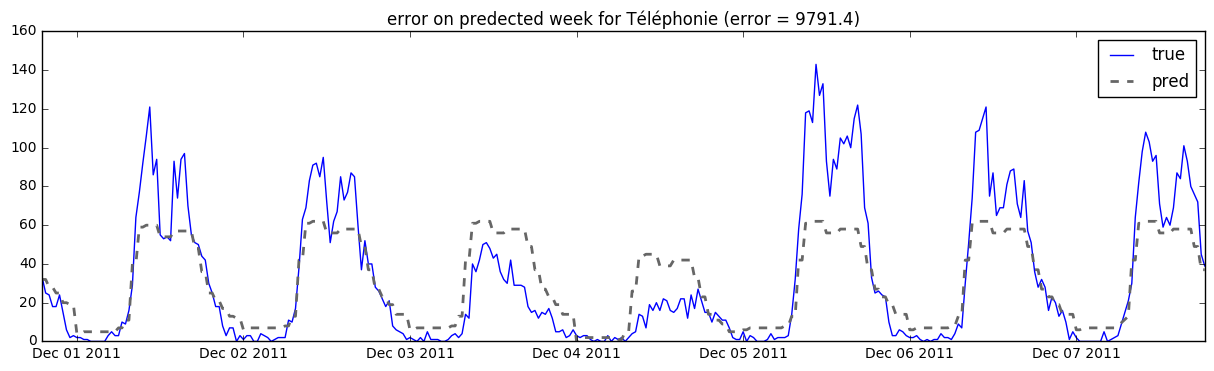

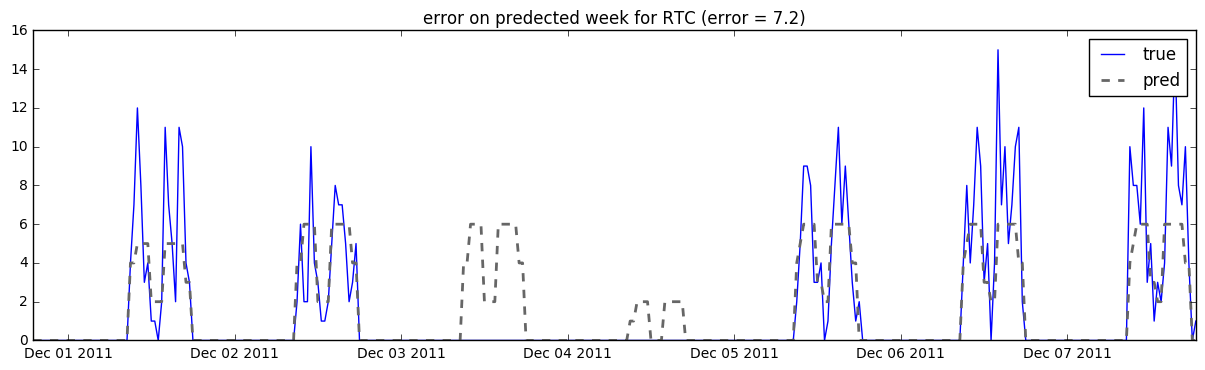

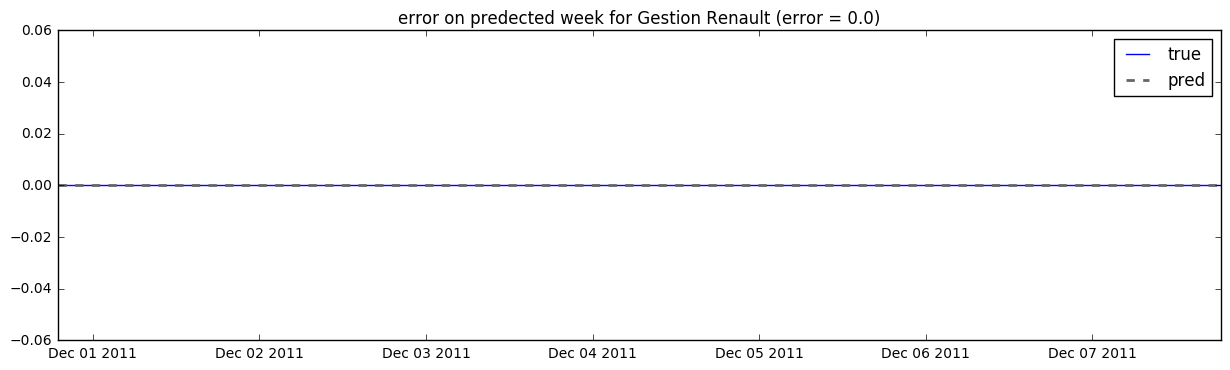

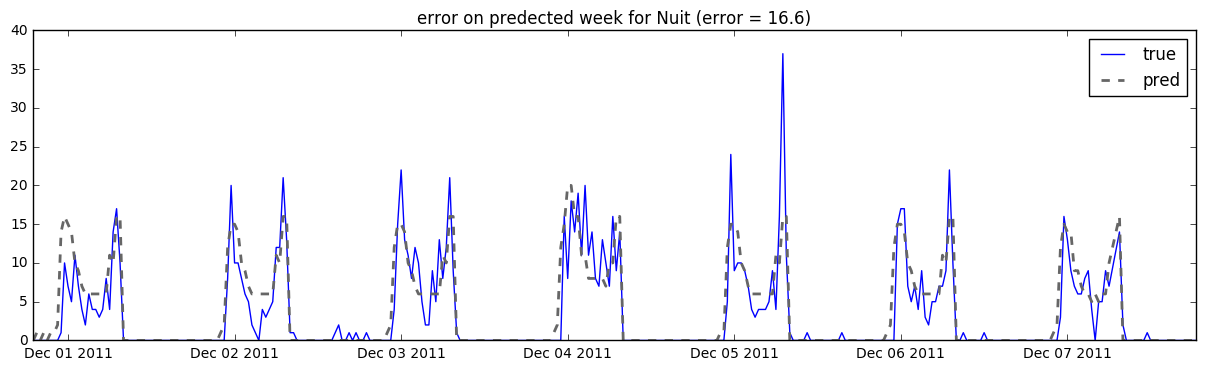

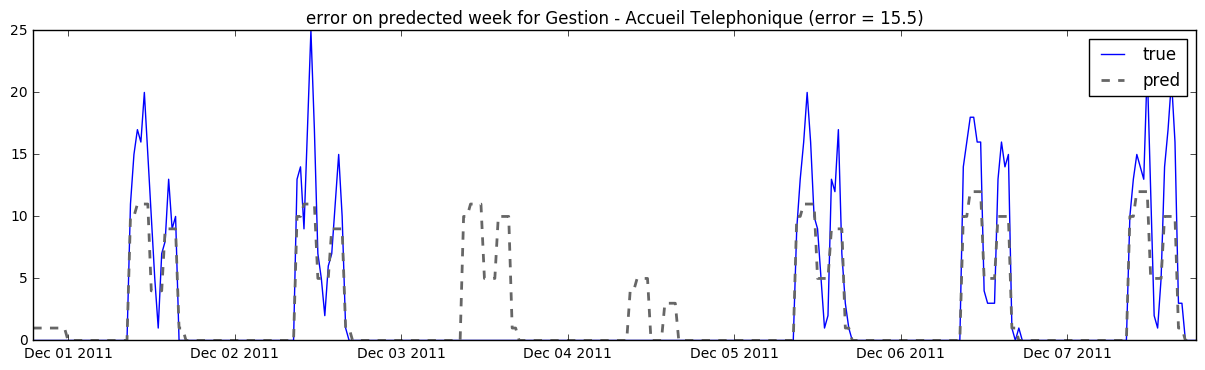

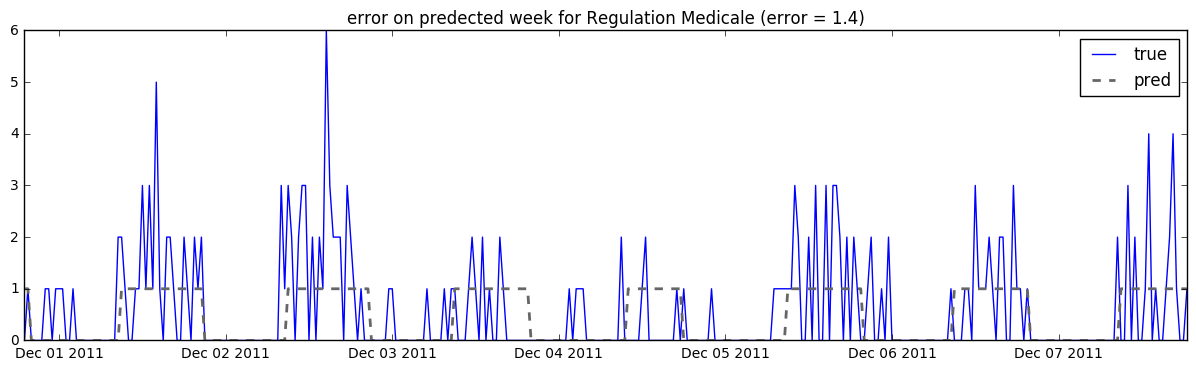

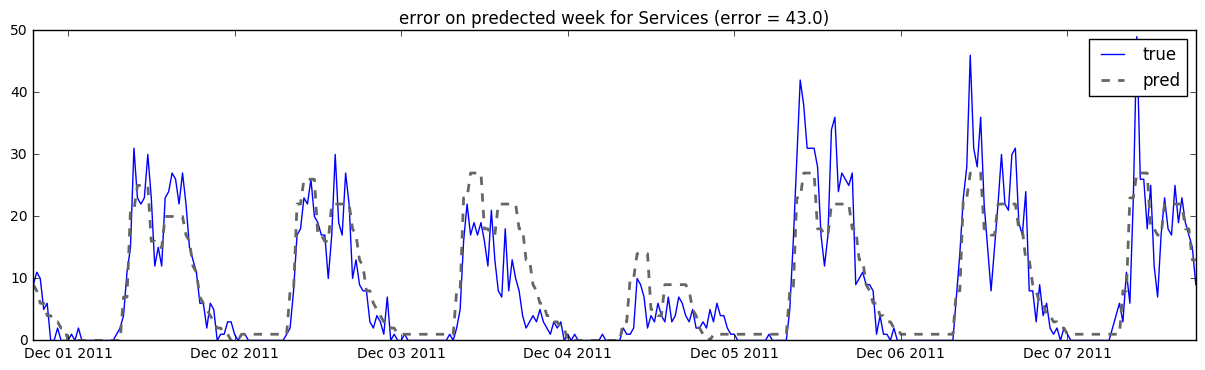

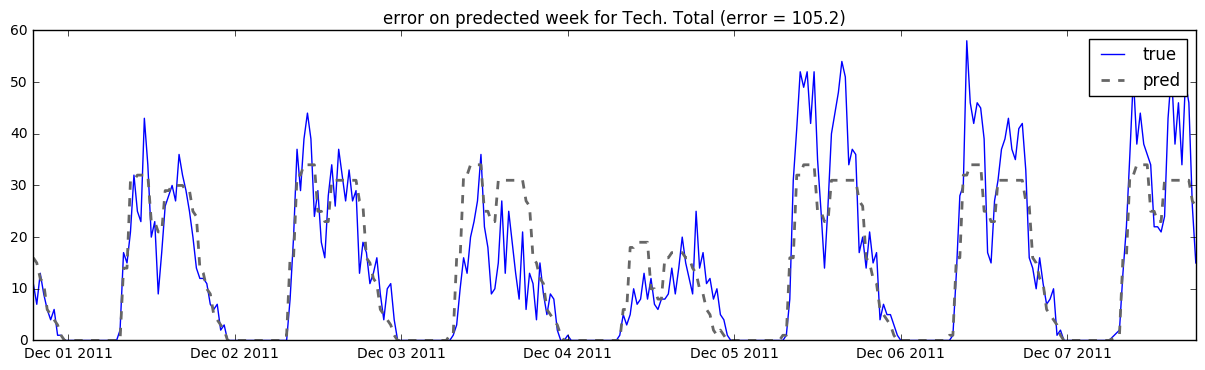

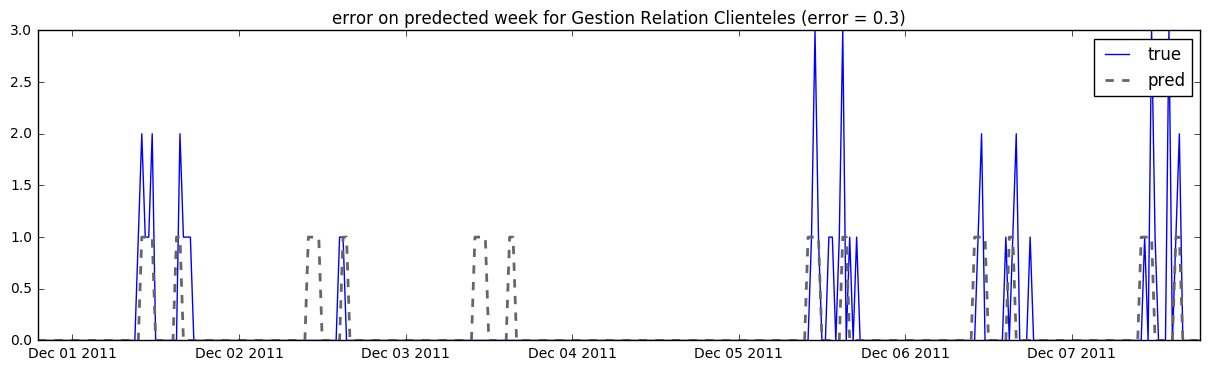

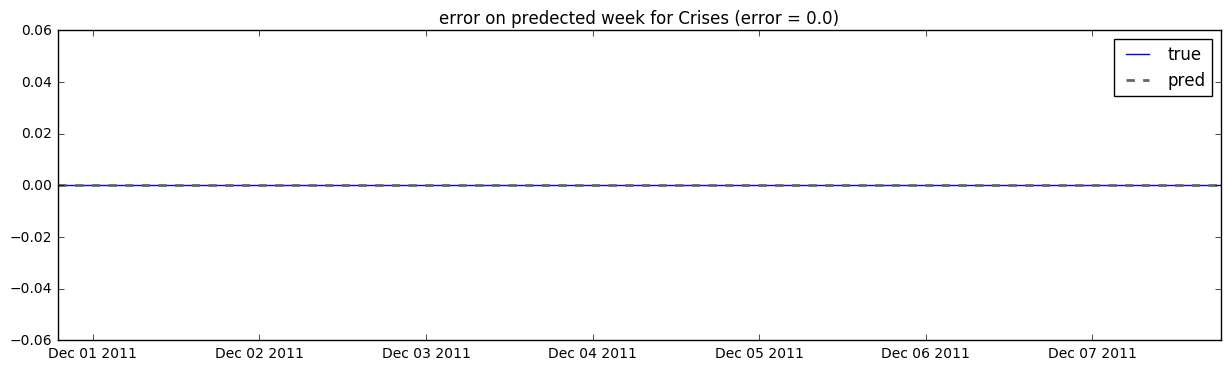

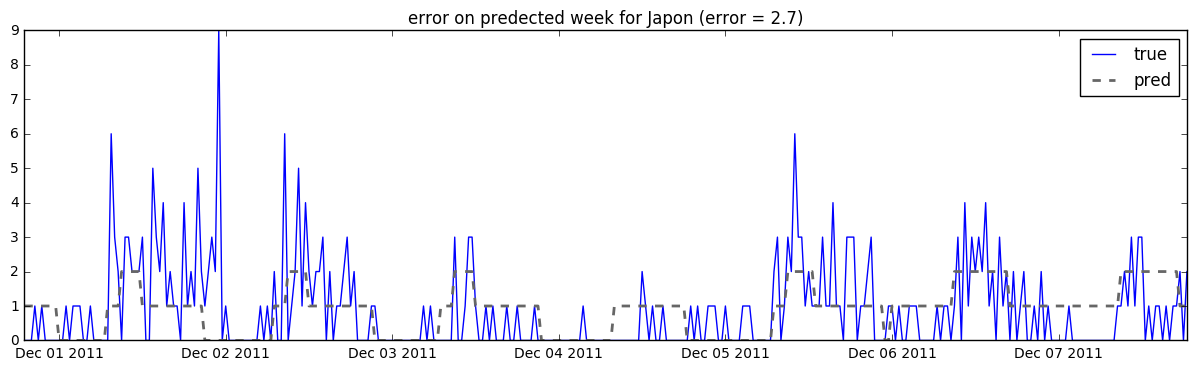

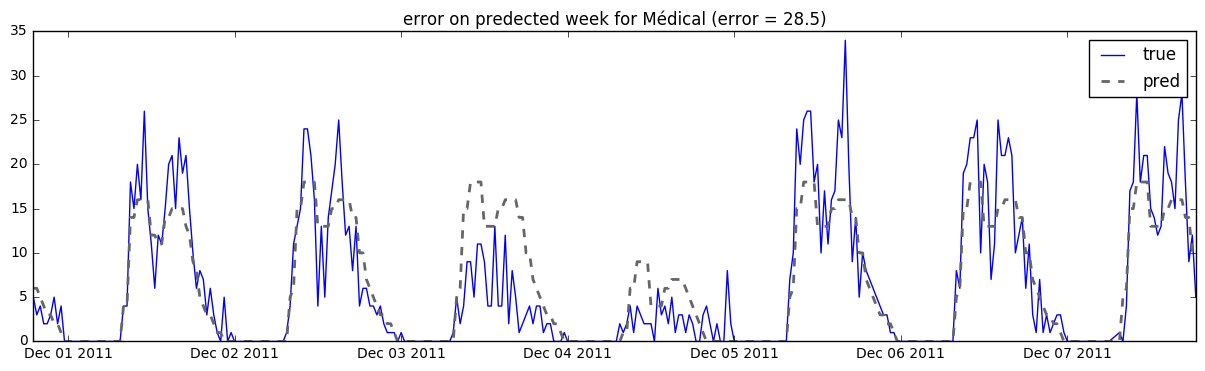

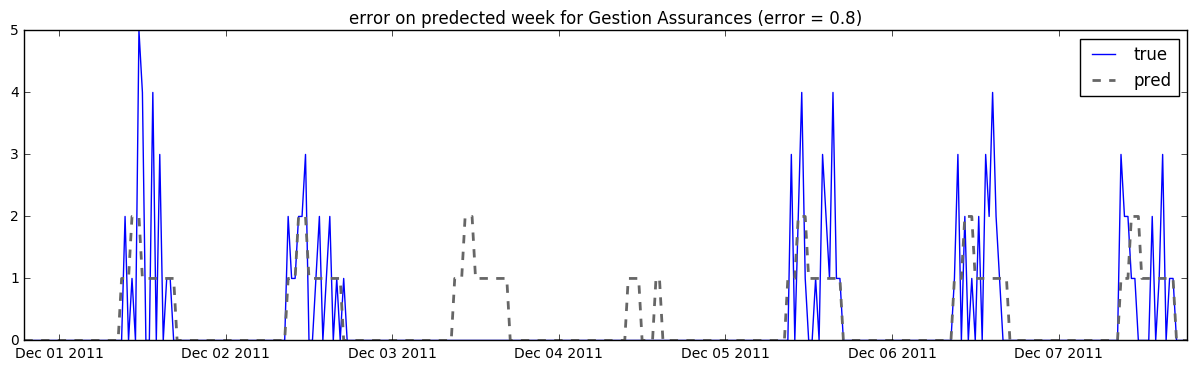

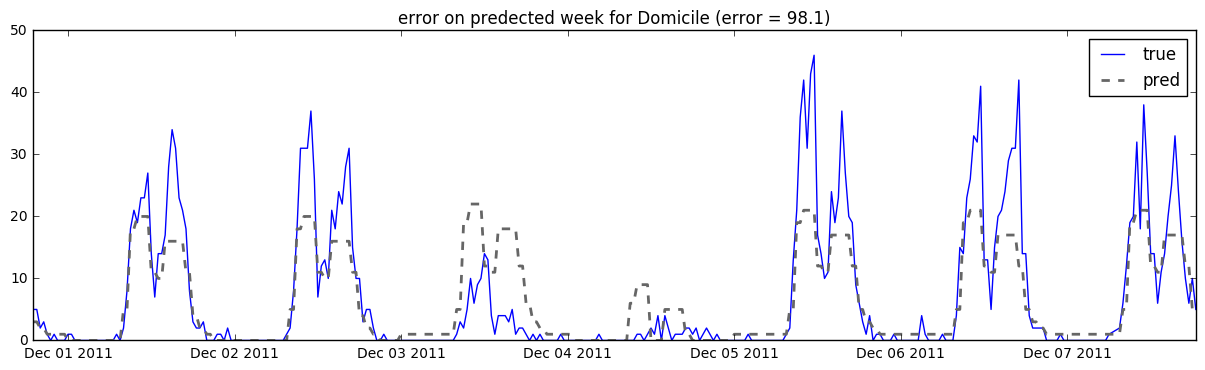

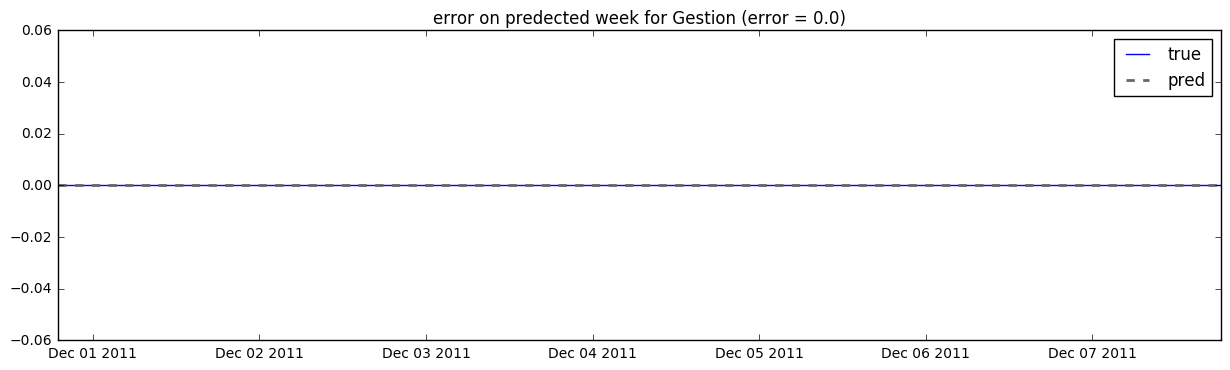

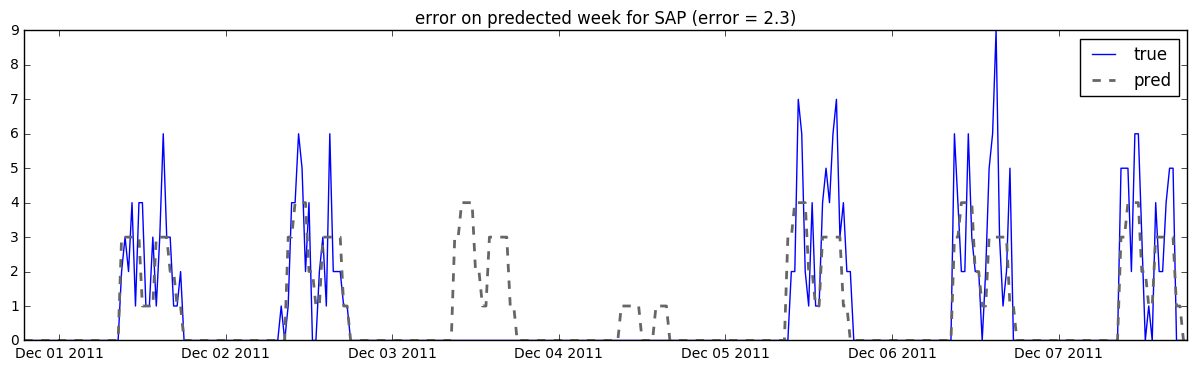

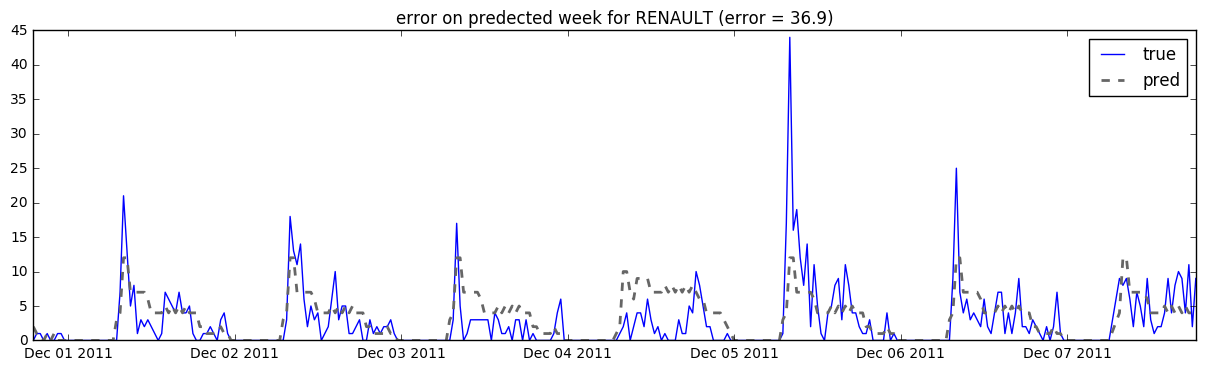

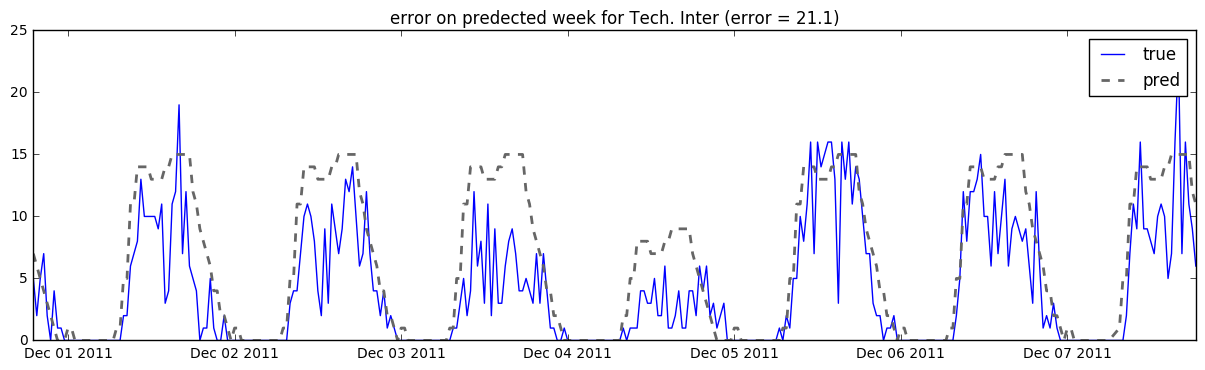

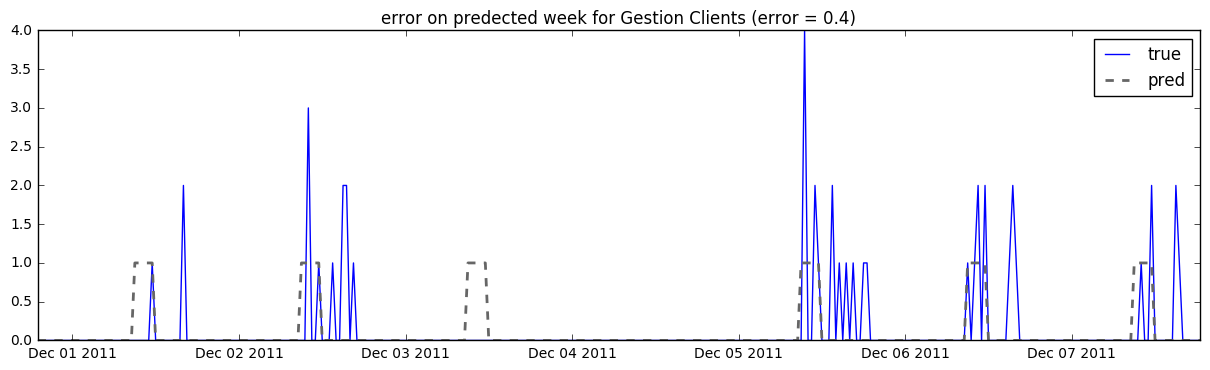

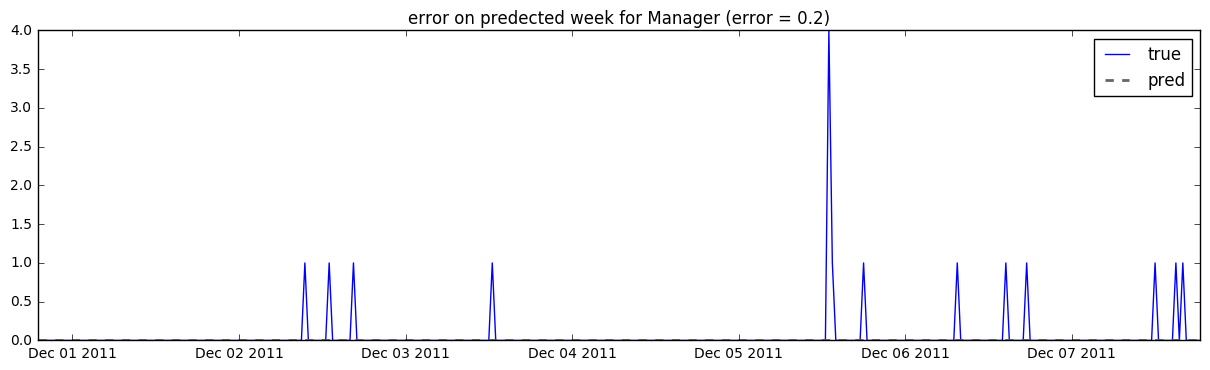

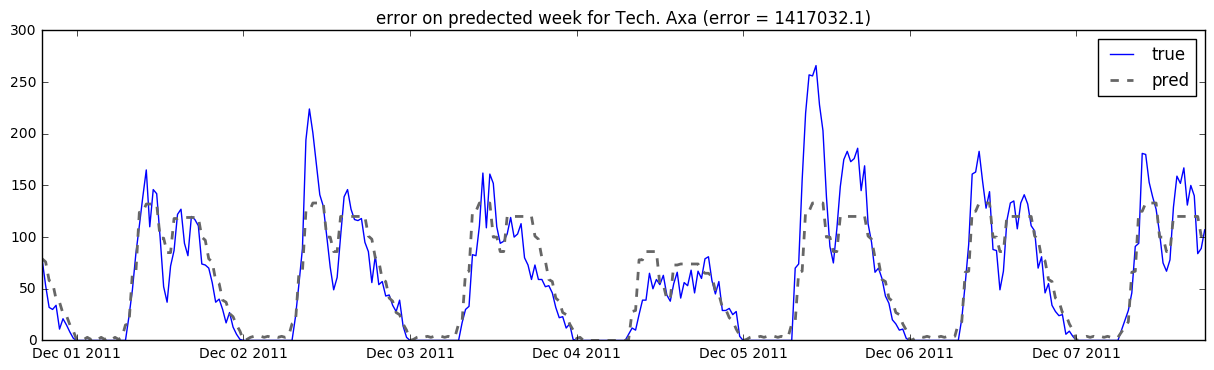

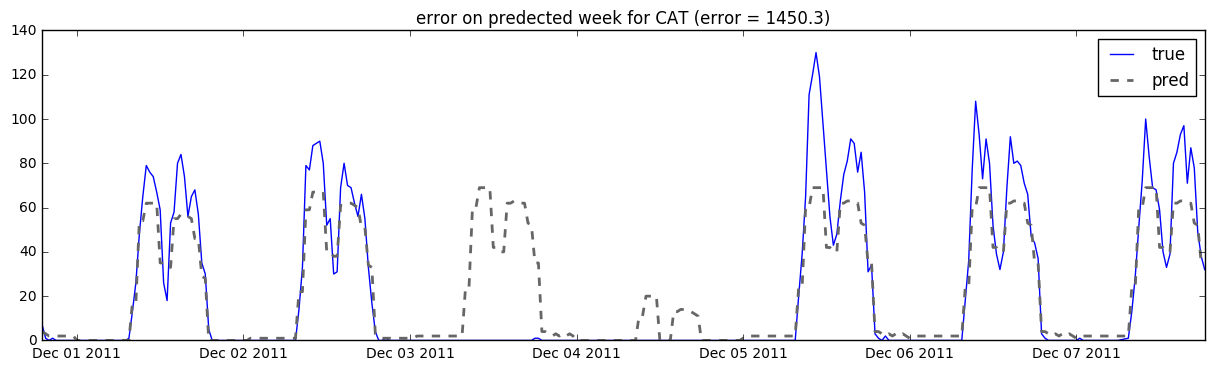

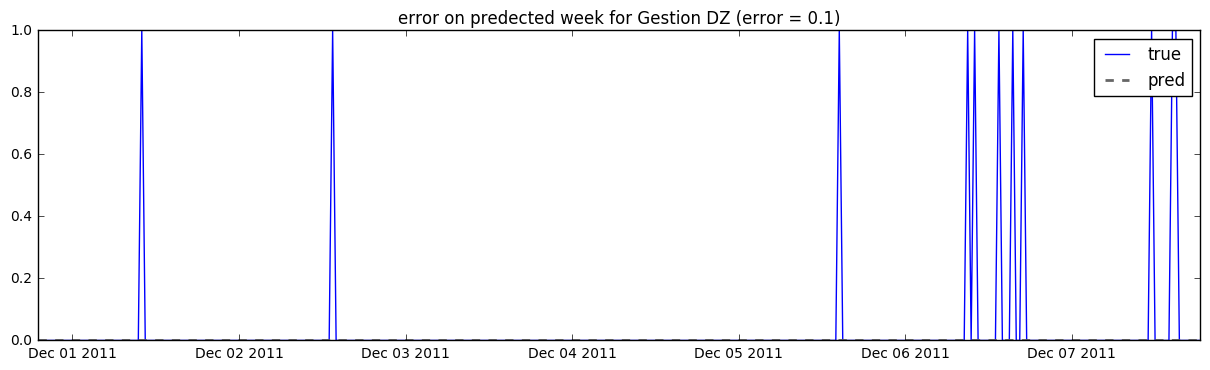

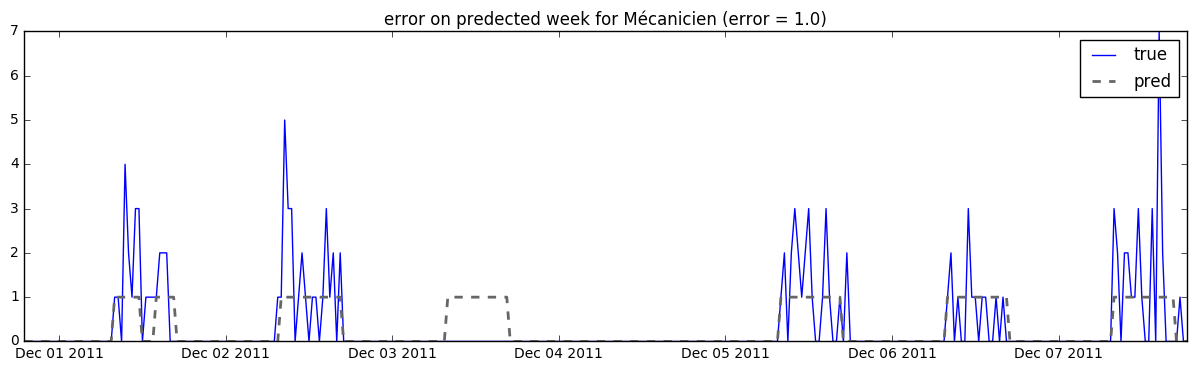

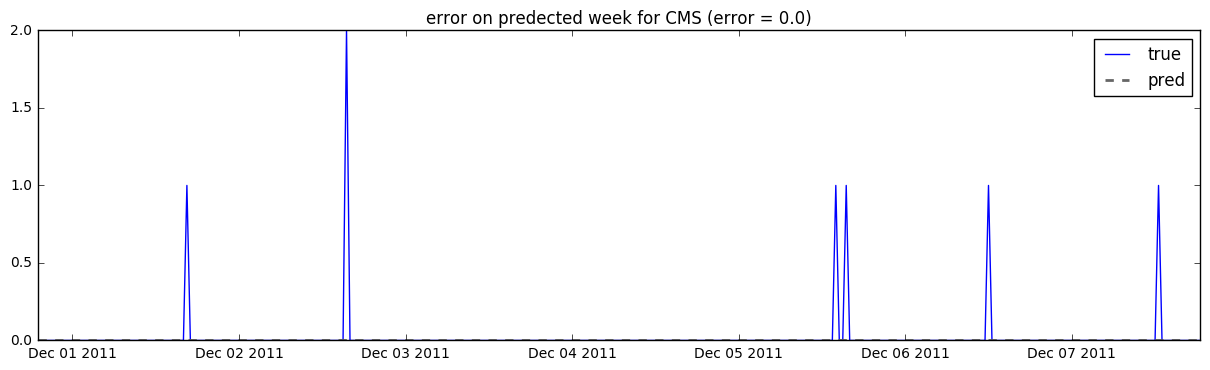

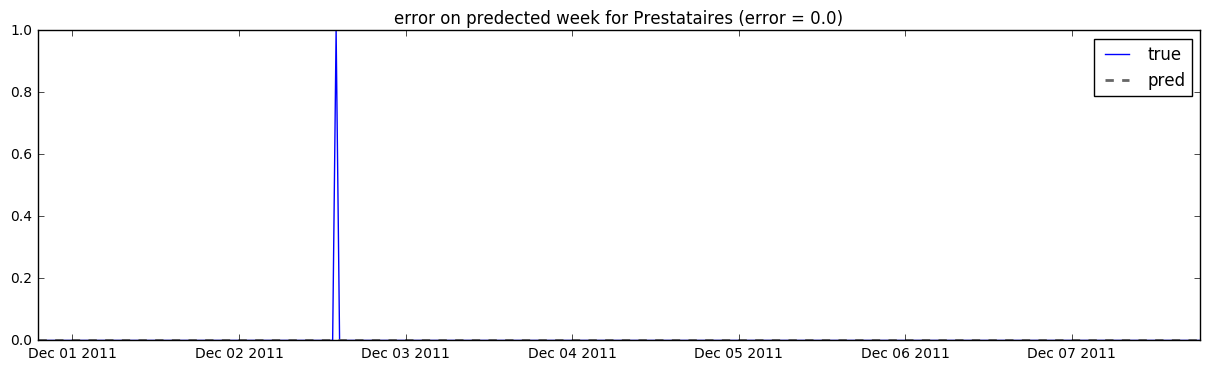

In [217]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Regressor, GS):
    
    y_train_reg = {}
    y_test_reg = {}
    reg = {}
    y_pred_reg = {}
    error = 0
    
    for cat in data.ASS_ASSIGNMENT.unique():
        print('%s' %cat.decode('utf-8'))
        if cat not in ['Evenements','Gestion Amex']:
            print('------------------------------------------------')
            # Spliting data for cross validation
            train_is, test_is = skf_is
            
            # test/train definition
            X_train_df = X_df.iloc[train_is].copy()
            base_col = ['year','month','day','hour','min','workingday','holiday','weekday']
            filter_col = [col for col in list(X_train_df) if (col.startswith(cat.decode('utf-8')) or col in base_col)]
            X_train_df = X_train_df[filter_col]
            y_train_df = y_df.iloc[train_is].copy()
            X_test_df = X_df.iloc[test_is].copy()
            X_test_df = X_test_df[filter_col]
            y_test_df = y_df.iloc[test_is].copy()
            
            
            if cat in ['Téléphonie']: #Tech. Axa','CAT'
                X_train_df = X_train_df.last('12m')
                y_train_df = y_train_df.last('12m')

            # casual/registered definition
            y_train_reg[cat] = y_train_df[cat].values
            y_test_reg[cat] = y_test_df[cat].values
            # y_test_reg = y_test_df['count'].values
            print("Done.")

            # Features extraction (no modification of data in this case)
            print("Exctracting features ..."),
            fe_reg = FeatureExtractor()
            fe_reg.fit(X_train_df, y_train_df)
            X_train_array_reg = fe_reg.transform(X_train_df)
            X_test_array_reg = fe_reg.transform(X_test_df)
            print("Done.")

            # Train
            print("Training algorithm for %s..." %cat.decode('utf-8')),
            # regressors initialisation
            reg[cat] = Regressor()

            # grid search to calibrate model before fitting
            if GS :
                if cat in ['Tech. Axa','Téléphonie','CAT']:
                    reg[cat].grid_search_fit(X_train_array_reg, y_train_reg[cat])

            # fitting model
            reg[cat].fit(X_train_array_reg, y_train_reg[cat])
            print("Done.")

            # Test
            print("Testing algorithm for %s..." %cat.decode('utf-8')),
            y_pred_reg[cat] = np.round(np.maximum(reg[cat].predict(X_test_array_reg),0),0)
            error_tmp = ef.linex_loss(y_pred_reg[cat], y_test_reg[cat])
            error += error_tmp

            print("Done.")
            print('error %s = %.0f' %(cat.decode('utf-8'),error_tmp))
            
            # plot figure for predicted week
            y_test_plt = pd.DataFrame(index = y_test_df.index)
            y_test_plt[cat.decode('utf-8')] = y_test_reg[cat]
            y_pred_plt = pd.DataFrame(index = y_test_df.index)
            y_pred_plt[cat.decode('utf-8')] = y_pred_reg[cat]
            
            fig = plt.figure(figsize=[15,4])
            plt.plot(y_test_plt[cat.decode('utf-8')])
            plt.plot(y_pred_plt[cat.decode('utf-8')], linestyle = 'dashed', color=gray_light, linewidth=2)
            plt.title('error on predected week for %s (error = %.1f)' %(cat.decode('utf-8'),error_tmp))
            plt.legend(['true','pred'])
            
            print('\n------------------------------------------------')
        else:
            print("pass.")
            print('------------------------------------------------')
    k = X_train_df.shape[0]+X_test_df.shape[0]
    l = X_train_df.shape[0]
    print('train sample size %% total sample size = %.2f%%' %(100*float(l)/k))
    print('error = %.1f' %(error))
    

a = X_train.shape[0]
b = X_train_CV.shape[0]
skf_is = ([np.arange(a-b).astype(int),np.arange(a-b,a).astype(int)])

train_test_model_clf(X_train, y_df, skf_is, FeatureExtractor, Regressor, False)

## Submission prediction

In [28]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def train_test_model_clf(X_train, X_test, y_train, FeatureExtractor):
    
    y_train_reg = {}
    y_test_reg = {}
    reg = {}
    y_pred_reg = {}
    error = 0
    first = True
    y_pred = np.zeros((submission.shape[0]))
    
    for cat in submission.ASS_ASSIGNMENT.unique():
        print('%s' %cat.decode('utf-8'))
        if cat not in ['Evenements','Gestion Amex']:
            print('------------------------------------------------')

            # test/train definition  
            X_train_df = X_train.copy()
            y_train_df = y_train.copy()
            X_test_df = X_test.copy()
            
            base_col = ['year','month','day','hour','min','workingday']
            filter_col = [col for col in list(X_train_df) if (col.startswith(cat.decode('utf-8')) or col in base_col)]          
            X_test_df = X_test_df[filter_col]
            X_train_df = X_train_df[filter_col]
            
            if cat in ['Téléphonie']: #'Tech. Axa','CAT'
                X_train_df = X_train_df.last('6m')
                y_train_df = y_train_df.last('6m')

            # cat definition
            y_train_reg[cat] = y_train_df[cat].values
            print("Done.")

            # Features extraction (no modification of data in this case)
            print("Exctracting features ..."),
            fe_reg = FeatureExtractor()
            fe_reg.fit(X_train_df, y_train_df)
            X_train_array_reg = fe_reg.transform(X_train_df)
            X_test_array_reg = fe_reg.transform(X_test_df)
            print("Done.")

            # Train
            print("Training algorithm for %s..." %cat.decode('utf-8')),
            # regressors initialisation
            reg[cat] = Regressor()

            # uncomment to perform grid search to calibrate model before fitting
            #if cat in ['Tech. Axa','Téléphonie','CAT']:
            #    reg[cat].grid_search_fit(X_train_array_reg, y_train_reg[cat])

            # fitting model
            reg[cat].fit(X_train_array_reg, y_train_reg[cat])            
            print("Done.")
            print('\n------------------------------------------------')
        else:
            print("pass.")
            print('------------------------------------------------')
    rep = pd.DataFrame(index = submission.index)
    #print(rep.shape)
    rep['DATE'] = submission.index
    rep['ASS_ASSIGNMENT'] = submission.ASS_ASSIGNMENT
    i = 0
    
    for index, row in rep.iterrows():
        cat = row['ASS_ASSIGNMENT']
        y_pred[i] = reg[cat].predict(X_test.loc[index])[0].astype(int)
        i+=1
    rep['prediction'] = np.maximum(y_pred.astype(int),0)

    print("saved in file")
    
    rep.to_csv("submission_test.txt", sep="\t", index=False)
    
train_test_model_clf(X_train, X_test, y_df, FeatureExtractor)

CMS
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for CMS... Done.

------------------------------------------------
Crises
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Crises... Done.

------------------------------------------------
Domicile
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Domicile... Done.

------------------------------------------------
Gestion
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Gestion... Done.

------------------------------------------------
Gestion - Accueil Telephonique
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Gestion - Accueil Telephonique... Done.

------------------------------------------------
Gestion Assurances
-----------------------

In [31]:
input_file = "submission_test.txt"
output_file = "submission_test_modif.txt"

modif = pd.read_csv(input_file, sep="\t")
print("File read.")
modif['DATE'] = [dd + ".000" for dd in modif['DATE']]
print("Data modified.")
modif.to_csv(output_file, sep="\t", index=False)
print("All done.")


File read.
Data modified.
All done.
